# Experiment Analysis

- How did the portfolio perform?
- Cumulative Returns - based on spot prices
- What happened during this period?
- How did it compare with the previous years?

## Learnings
- Managing Leverage - monitoring leverage profile of portfolio - how does it change over time
  - Binomial tree of prices
- Strategy Rebalancing
- How will it usually perform after?

# What happened to the portfolio?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_hl = pd.read_excel("funding_data.xlsx")
df_hl['date'] = pd.to_datetime(df_hl['date'], format='%d/%m/%Y %H:%M').dt.date
df_hl

,date,price,balance,funding,liquidation_price,margin
0,2025-02-10,96907,2447.57,-6.76,NaN,NaN
1,2025-02-17,96250,2395.58,-17.71,49815.0,0.0205
2,2025-02-26,88666,2007.49,-30.01,50058.0,0.0205
3,2025-02-28,79516,1524.13,-32.95,50116.0,0.0266
4,2025-03-07,89926,2055.79,-35.84,50173.0,0.0223
5,2025-03-11,78812,1482.30,-40.87,50273.0,0.0272
6,2025-03-17,83594,1727.12,-39.29,50242.0,0.0247
7,2025-03-24,85500,1822.95,-42.34,50302.0,0.0239
8,2025-03-31,81704,1627.31,-44.43,50343.0,0.0256


In [3]:
df_hl.iloc[-1]['date'] - df_hl.iloc[0]['date']

datetime.timedelta(days=49)

In [4]:
df_spot = pd.read_csv("btc_spot.csv", sep = ';')[['timeOpen', 'open', 'volume', 'marketCap']]
df_spot['date'] = pd.to_datetime(df_spot['timeOpen'], format='%Y-%m-%dT%H:%M:%S.%fZ').dt.date
df_spot = df_spot.sort_values(by='date').reset_index(drop=True)
df_spot.head(5)

,timeOpen,open,volume,marketCap,date
0,2025-02-02T00:00:00.000Z,100661.536387,6.309182e+10,1.935747e+12,2025-02-02
1,2025-02-03T00:00:00.000Z,97681.103256,1.154009e+11,2.009571e+12,2025-02-03
2,2025-02-04T00:00:00.000Z,101398.717040,7.300213e+10,1.939248e+12,2025-02-04
3,2025-02-05T00:00:00.000Z,97878.009754,4.912591e+10,1.915014e+12,2025-02-05
4,2025-02-06T00:00:00.000Z,96610.640228,4.530247e+10,1.914350e+12,2025-02-06


In [5]:
df_combined = df_spot.merge(df_hl, on='date', how='left')
df_combined['returns'] = df_combined['open'] / df_combined['open'].shift(1) - 1
df_combined['returns_cum'] = (df_combined['returns'] + 1).cumprod()
df_combined.tail(5)

,timeOpen,open,volume,marketCap,date,price,balance,funding,liquidation_price,margin,returns,returns_cum
53,2025-03-27T00:00:00.000Z,86896.254876,2.441347e+10,1.730011e+12,2025-03-27,NaN,NaN,NaN,NaN,NaN,-0.006448,0.863252
54,2025-03-28T00:00:00.000Z,87185.234677,3.419862e+10,1.673833e+12,2025-03-28,NaN,NaN,NaN,NaN,NaN,0.003326,0.866123
55,2025-03-29T00:00:00.000Z,84352.072726,1.696940e+10,1.639041e+12,2025-03-29,NaN,NaN,NaN,NaN,NaN,-0.032496,0.837977
56,2025-03-30T00:00:00.000Z,82596.983234,1.476376e+10,1.633898e+12,2025-03-30,NaN,NaN,NaN,NaN,NaN,-0.020807,0.820542
57,2025-03-31T00:00:00.000Z,82336.059346,2.900423e+10,1.638221e+12,2025-03-31,81704.0,1627.31,-44.43,50343.0,0.0256,-0.003159,0.817950


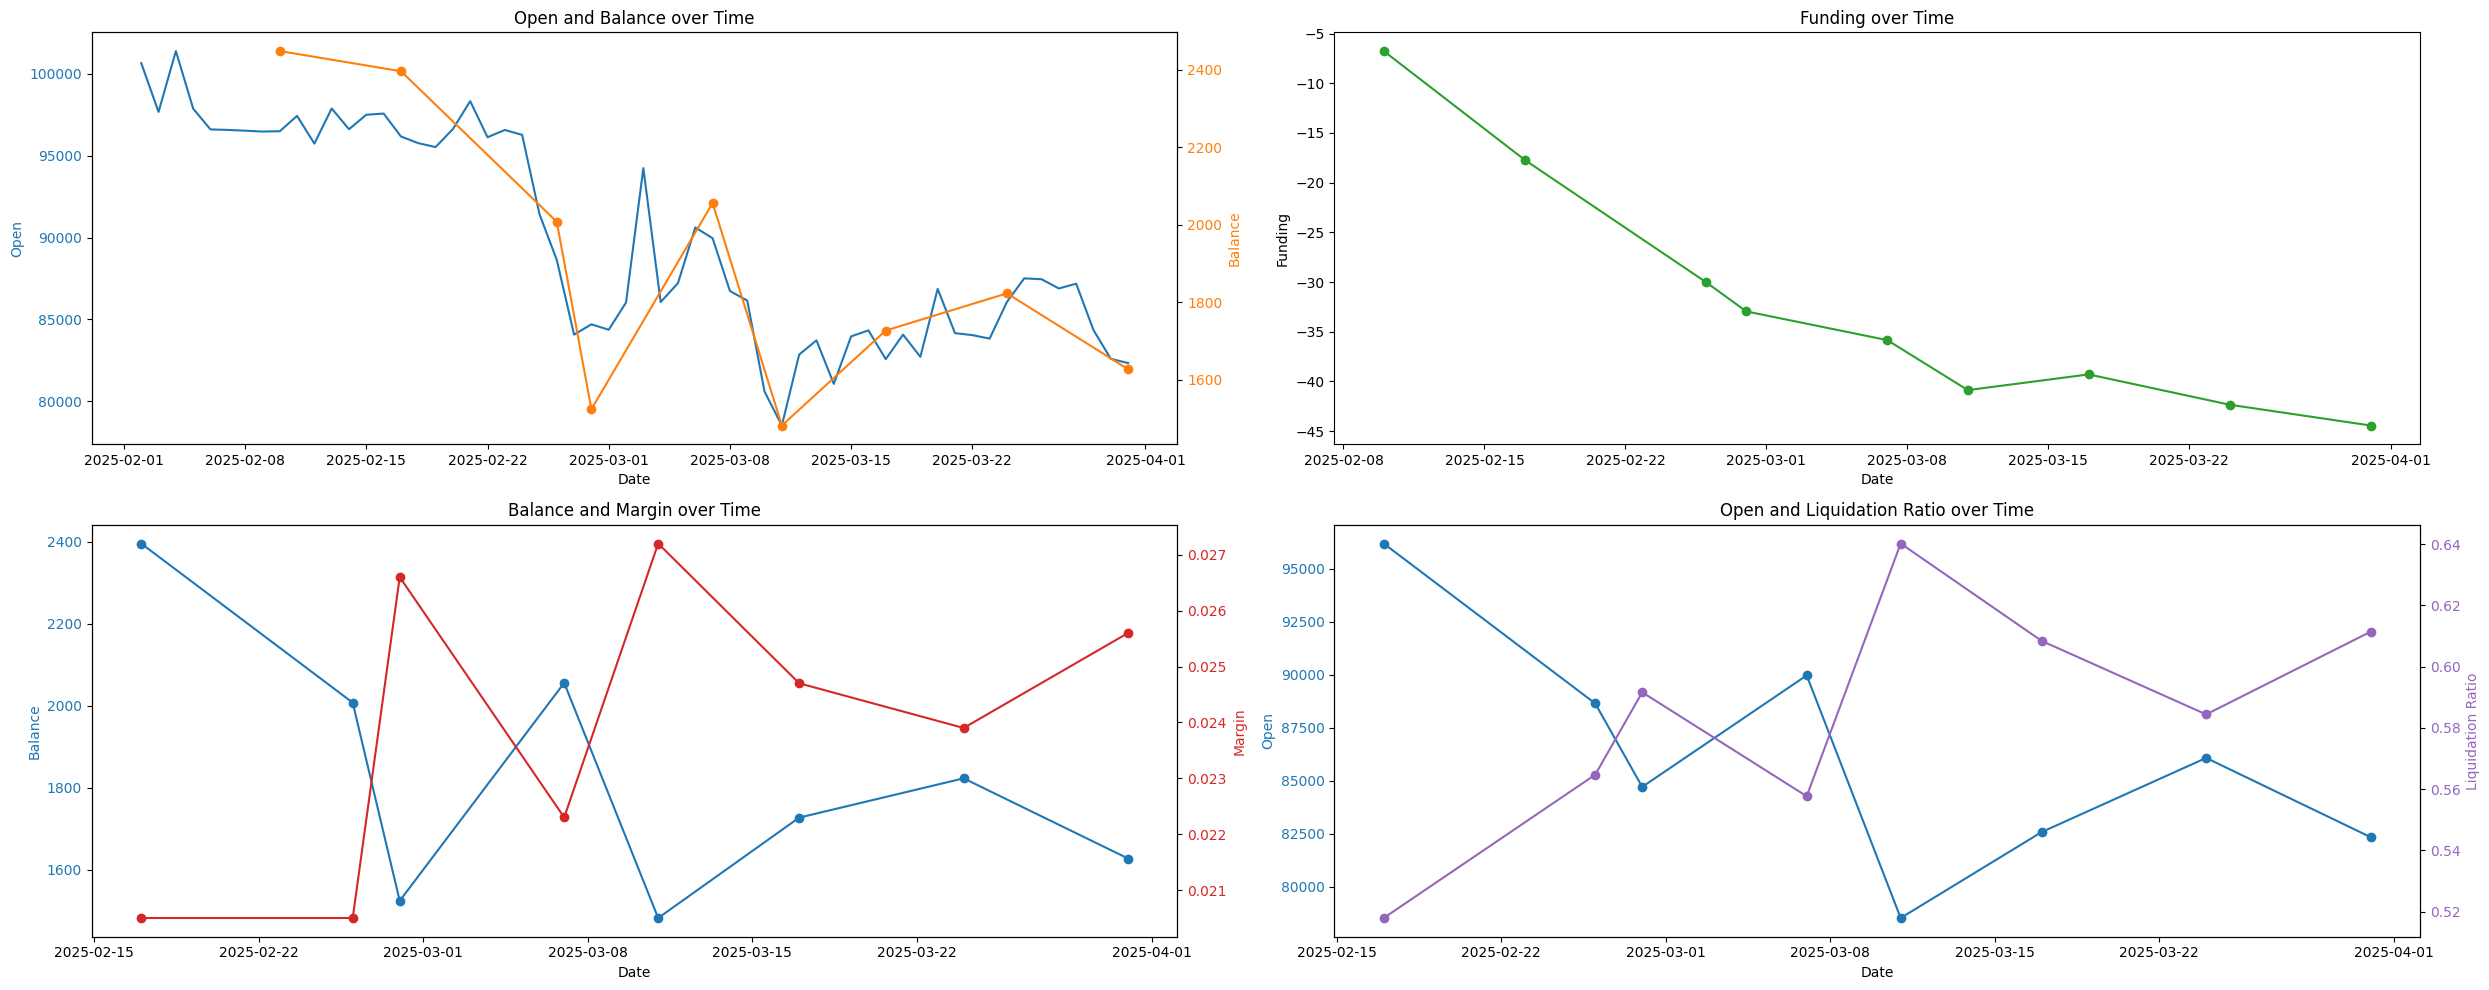

In [6]:
def plot_liquidation(df_hl):
    df = df_hl.copy()
    df['liquidation_ratio'] = df['liquidation_price'] / df['open']

    fig, axes = plt.subplots(2, 2, figsize=(25, 10))

    # Plot 1: left = open, right = balance
    ax1 = axes[0, 0]
    sub_df1 = df[['date', 'open', 'balance']].dropna()
    ax1.plot(df['date'], df['open'], color='tab:blue')
    ax1.set_ylabel('Open', color='tab:blue')
    ax1.set_title('Open and Balance over Time')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_xlabel('Date')

    ax1_right = ax1.twinx()
    ax1_right.plot(sub_df1['date'], sub_df1['balance'], color='tab:orange', marker ='o')
    ax1_right.set_ylabel('Balance', color='tab:orange')
    ax1_right.tick_params(axis='y', labelcolor='tab:orange')

    # Plot 2: Funding
    ax2 = axes[0, 1]
    sub_df2 = df[['date', 'funding']].dropna()
    ax2.plot(sub_df2['date'], sub_df2['funding'], color='tab:green', marker ='o')
    ax2.set_title('Funding over Time')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Funding')

    # Plot 3: left = balance, right = margin
    ax3 = axes[1, 0]
    sub_df3 = df[['date', 'balance', 'margin']].dropna()
    ax3.plot(sub_df3['date'], sub_df3['balance'], color='tab:blue', marker ='o')
    ax3.set_ylabel('Balance', color='tab:blue')
    ax3.set_title('Balance and Margin over Time')
    ax3.tick_params(axis='y', labelcolor='tab:blue')
    ax3.set_xlabel('Date')

    ax3_right = ax3.twinx()
    ax3_right.plot(sub_df3['date'], sub_df3['margin'], color='tab:red', marker ='o')
    ax3_right.set_ylabel('Margin', color='tab:red')
    ax3_right.tick_params(axis='y', labelcolor='tab:red')

    # Plot 4: left = open, right = liquidation ratio
    ax4 = axes[1, 1]
    sub_df4 = df[['date', 'open', 'liquidation_ratio']].dropna()
    ax4.plot(sub_df4['date'], sub_df4['open'], color='tab:blue', marker ='o')
    ax4.set_ylabel('Open', color='tab:blue')
    ax4.set_title('Open and Liquidation Ratio over Time')
    ax4.tick_params(axis='y', labelcolor='tab:blue')
    ax4.set_xlabel('Date')

    ax4_right = ax4.twinx()
    ax4_right.plot(sub_df4['date'], sub_df4['liquidation_ratio'], color='tab:purple', marker ='o')
    ax4_right.set_ylabel('Liquidation Ratio', color='tab:purple')
    ax4_right.tick_params(axis='y', labelcolor='tab:purple')

    plt.tight_layout()
    plt.show()

# plot_liqudation(df_hl)

plot_liquidation(df_combined)

## Performance of the strategy

In [55]:
def print_strategy_metrics(df, rfr=0.04):
    """
    Print performance metrics of a long strategy.
    
    Parameters:
    df (pd.DataFrame): Must contain columns 'returns' (daily) and 'returns_cum' (cumulative return).
    rfr (float): Risk-free rate (annualised).
    """
    mean_return = df['returns'].mean()
    std_return = df['returns'].std()
    sharpe_ratio = (mean_return - rfr / 252) / std_return  # daily Sharpe from annual RFR

    total_return = df.iloc[-1]['returns_cum']
    max_drawdown = df['returns_cum'].min() / df['returns_cum'].max() - 1
    # drawdown = 1 - total_return

    print("Strategy Performance Metrics")
    print("----------------------------")
    print(f"Return: {1 - total_return:.2%}")
    print(f"Max Drawdown: {max_drawdown:.2%}")
    print(f"Average Daily Return: {(mean_return) * 100:.4f}%")
    print(f"Daily Volatility: {(std_return) * 100:.4f}%")
    print(f"Sharpe Ratio (annualized): {sharpe_ratio * (365 ** 0.5):.2f}")
    print(f"Final Portfolio Value: {df.iloc[-1]['balance']:.2f}")
    print(f"PnL : {df.iloc[-1]['balance'] - 2500:.2f}")
    print(f"Funding Fees: {df.iloc[-1]['funding']:.2f}")

print_strategy_metrics(df_combined)

Strategy Performance Metrics
----------------------------
Return: 18.21%
Max Drawdown: -22.56%
Average Daily Return: -0.3088%
Daily Volatility: 2.9634%
Sharpe Ratio (annualized): -2.09
Final Portfolio Value: 1627.31
PnL : -872.69
Funding Fees: -44.43


# How did this compare to the backtest?

In [8]:
from datetime import datetime
import requests
import pytz

def get_binance_spot(symbol, interval, startTime, endTime):
    url = "https://api.binance.com/api/v3/klines"
    print(f"""Querying {symbol} from {datetime.fromtimestamp(startTime/1000).strftime("%Y-%m-%d %H:%M:%S")} to {datetime.fromtimestamp(endTime/1000).strftime("%Y-%m-%d %H:%M:%S")}""")
    queryTime = startTime
    all_data = []
    while queryTime < endTime:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": queryTime,
            "timeZone": 0,
            "limit": 1000
        }
        response = requests.get(url, params=params)
        data = response.json()
        # return data
        if len(data) == 0:
            break
        queryTime = data[-1][0] + 1
        all_data.extend(data)
    return all_data

startTime = int(datetime(2020, 1,1 , tzinfo=pytz.UTC).timestamp() * 1000)
endTime = int(datetime(2024, 12, 31, 23 , 59, tzinfo=pytz.UTC).timestamp() * 1000)

data_spot_btc = get_binance_spot("BTCUSDT", "1h", startTime=startTime, endTime=endTime)
# data_spot_btc
df_spot_btc = pd.DataFrame(data_spot_btc, columns=["timestamp", "open", "high", "low", "close", "volume", "close_time", "quote_asset_volume", "number_of_trades", "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume", "ignore"]).astype(float)
df_spot_btc["datetime"] = pd.to_datetime(df_spot_btc["timestamp"], unit="ms")
df_spot_btc = df_spot_btc[df_spot_btc['timestamp'] <= endTime]
df_spot_btc = df_spot_btc[['timestamp', 'datetime', 'open', 'high', 'low', 'close', 'volume']]
df_spot_btc

Querying BTCUSDT from 2020-01-01 08:00:00 to 2025-01-01 07:59:00


,timestamp,datetime,open,high,low,close,volume
0,1.577837e+12,2020-01-01 00:00:00,7195.24,7196.25,7175.46,7177.02,511.814901
1,1.577840e+12,2020-01-01 01:00:00,7176.47,7230.00,7175.71,7216.27,883.052603
2,1.577844e+12,2020-01-01 02:00:00,7215.52,7244.87,7211.41,7242.85,655.156809
3,1.577848e+12,2020-01-01 03:00:00,7242.66,7245.00,7220.00,7225.01,783.724867
4,1.577851e+12,2020-01-01 04:00:00,7225.00,7230.00,7215.03,7217.27,467.812578
...,...,...,...,...,...,...,...
43811,1.735672e+12,2024-12-31 19:00:00,93875.69,94290.91,93712.45,94166.88,462.793420
43812,1.735675e+12,2024-12-31 20:00:00,94166.88,94222.50,93450.17,93564.04,733.041470
43813,1.735679e+12,2024-12-31 21:00:00,93564.01,93964.15,93504.67,93899.68,337.527150
43814,1.735682e+12,2024-12-31 22:00:00,93899.67,93899.67,93375.58,93488.84,315.532720


In [9]:
df_spot_btc['returns'] = df_spot_btc['open'] / df_spot_btc['open'].shift(1) - 1
df_spot_btc['quarter'] = df_spot_btc['datetime'].dt.quarter
df_spot_btc['year'] = df_spot_btc['datetime'].dt.year
df_spot_btc['month'] = df_spot_btc['datetime'].dt.month
df_spot_btc

,timestamp,datetime,open,high,low,close,volume,returns,quarter,year,month
0,1.577837e+12,2020-01-01 00:00:00,7195.24,7196.25,7175.46,7177.02,511.814901,NaN,1,2020,1
1,1.577840e+12,2020-01-01 01:00:00,7176.47,7230.00,7175.71,7216.27,883.052603,-0.002609,1,2020,1
2,1.577844e+12,2020-01-01 02:00:00,7215.52,7244.87,7211.41,7242.85,655.156809,0.005441,1,2020,1
3,1.577848e+12,2020-01-01 03:00:00,7242.66,7245.00,7220.00,7225.01,783.724867,0.003761,1,2020,1
4,1.577851e+12,2020-01-01 04:00:00,7225.00,7230.00,7215.03,7217.27,467.812578,-0.002438,1,2020,1
...,...,...,...,...,...,...,...,...,...,...,...
43811,1.735672e+12,2024-12-31 19:00:00,93875.69,94290.91,93712.45,94166.88,462.793420,-0.002605,4,2024,12
43812,1.735675e+12,2024-12-31 20:00:00,94166.88,94222.50,93450.17,93564.04,733.041470,0.003102,4,2024,12
43813,1.735679e+12,2024-12-31 21:00:00,93564.01,93964.15,93504.67,93899.68,337.527150,-0.006402,4,2024,12
43814,1.735682e+12,2024-12-31 22:00:00,93899.67,93899.67,93375.58,93488.84,315.532720,0.003587,4,2024,12


In [10]:
def plot_returns_distribution(df):

    unique_years = df['year'].dropna().unique()
    unique_years.sort()
    n_years = len(unique_years)

    fig, axes = plt.subplots(n_years, 1, figsize=(10, 4 * n_years), constrained_layout=True)

    summary_data = []

    for i, year in enumerate(unique_years):
        ax = axes[i] if n_years > 1 else axes
        yearly_data = df[df['year'] == year]['returns'].dropna()
        
        mean_val = yearly_data.mean()
        std_val = yearly_data.std()
        q25 = yearly_data.quantile(0.25)
        q50 = yearly_data.quantile(0.5)

        # Histogram
        ax.axvline(mean_val, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_val:.4f}')
        ax.axvline(std_val, color='green', linestyle='dashed', linewidth=1, label=f'Std: {std_val:.4f}')
        ax.axvline(q25, color='blue', linestyle='dashed', linewidth=1, label=f'Q25: {q25:.4f}')
        ax.axvline(q50, color='purple', linestyle='dashed', linewidth=1, label=f'Q50: {q50:.4f}')
        ax.legend()
        ax.axvline(0, color='black', linestyle='dashed', linewidth=1)
        ax.hist(yearly_data, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        ax.set_title(f'Returns Distribution for {year}')
        ax.set_xlabel('Returns')
        ax.set_ylabel('Frequency')

        # Save summary
        summary_data.append({
            'year': year,
            'mean': mean_val,
            'std': std_val,
            'q25': q25,
            'q50': q50
        })

    plt.show()
    return pd.DataFrame(summary_data)

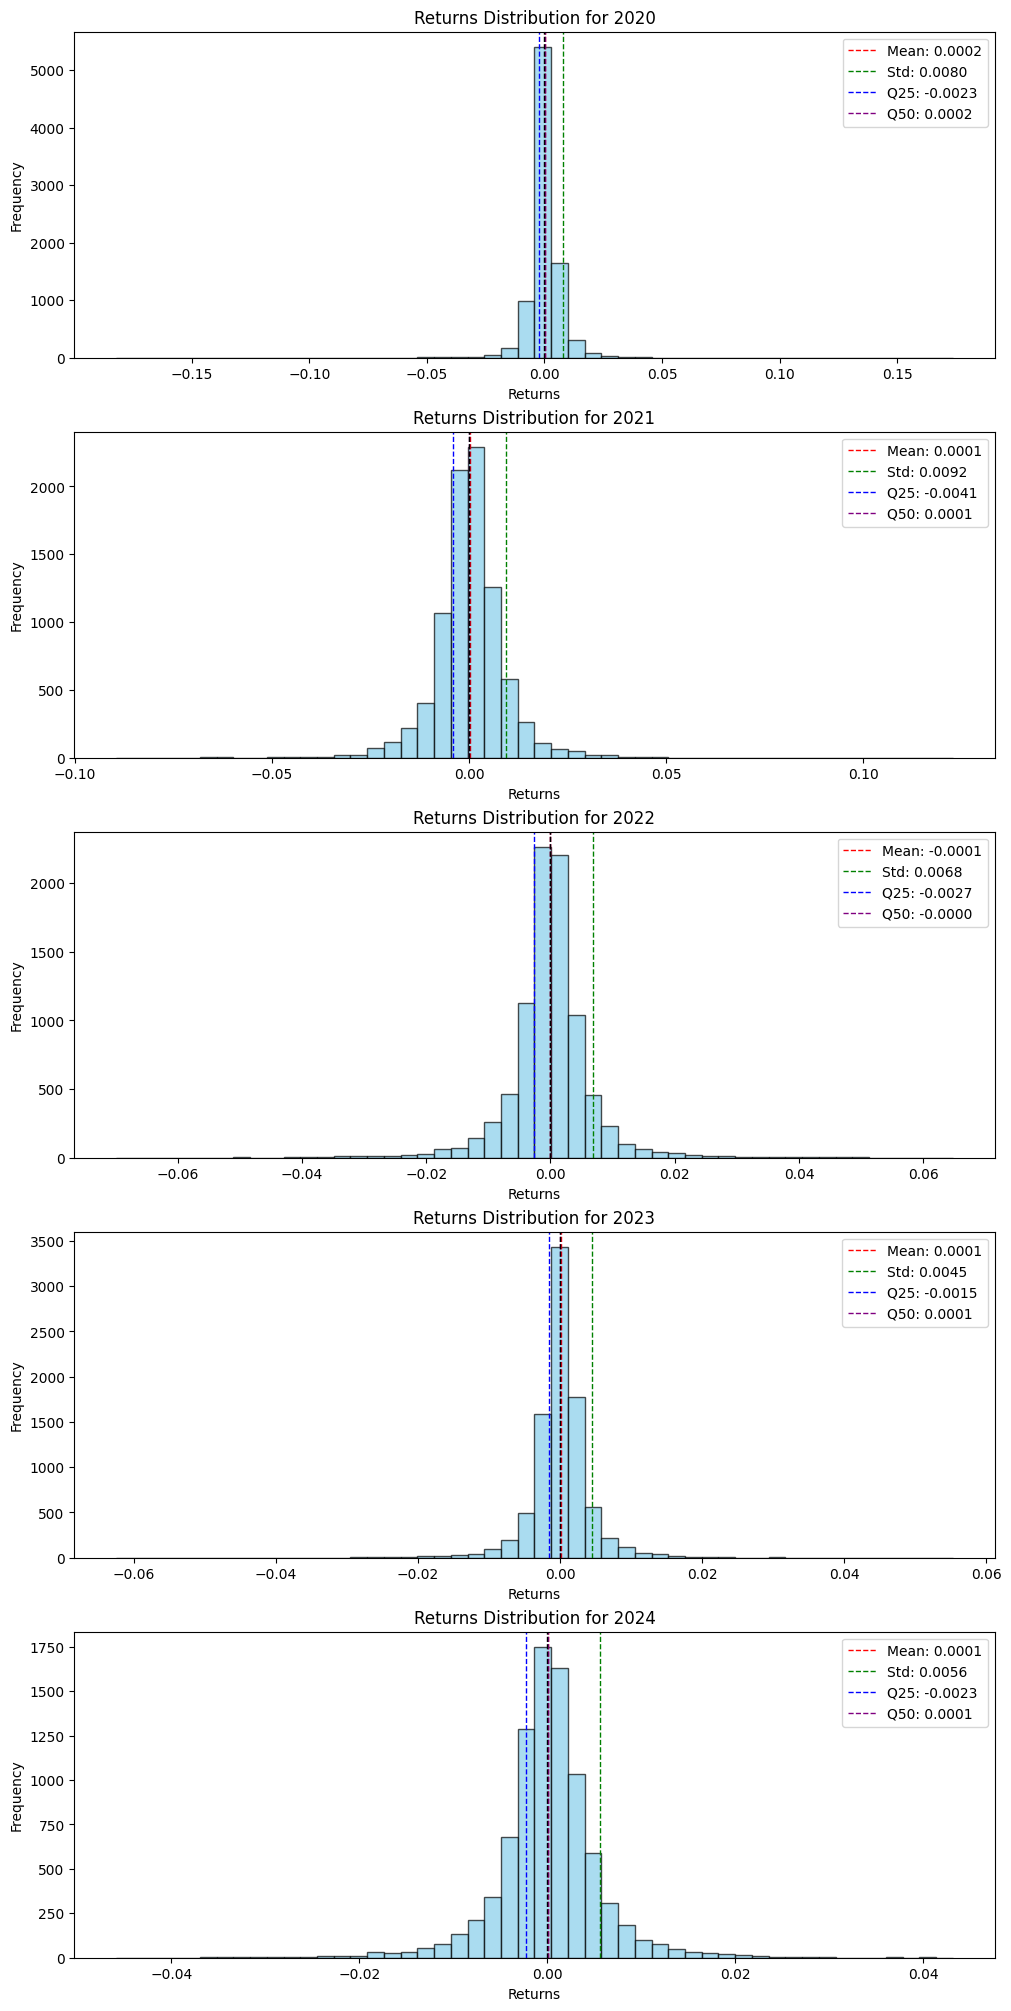

,year,mean,std,q25,q50
0,2020,0.000192,0.007970,-0.002282,0.000155
1,2021,0.000095,0.009201,-0.004110,0.000057
2,2022,-0.000094,0.006812,-0.002672,-0.000021
3,2023,0.000118,0.004542,-0.001531,0.000074
4,2024,0.000106,0.005617,-0.002277,0.000090


In [11]:
plot_returns_distribution(df_spot_btc)

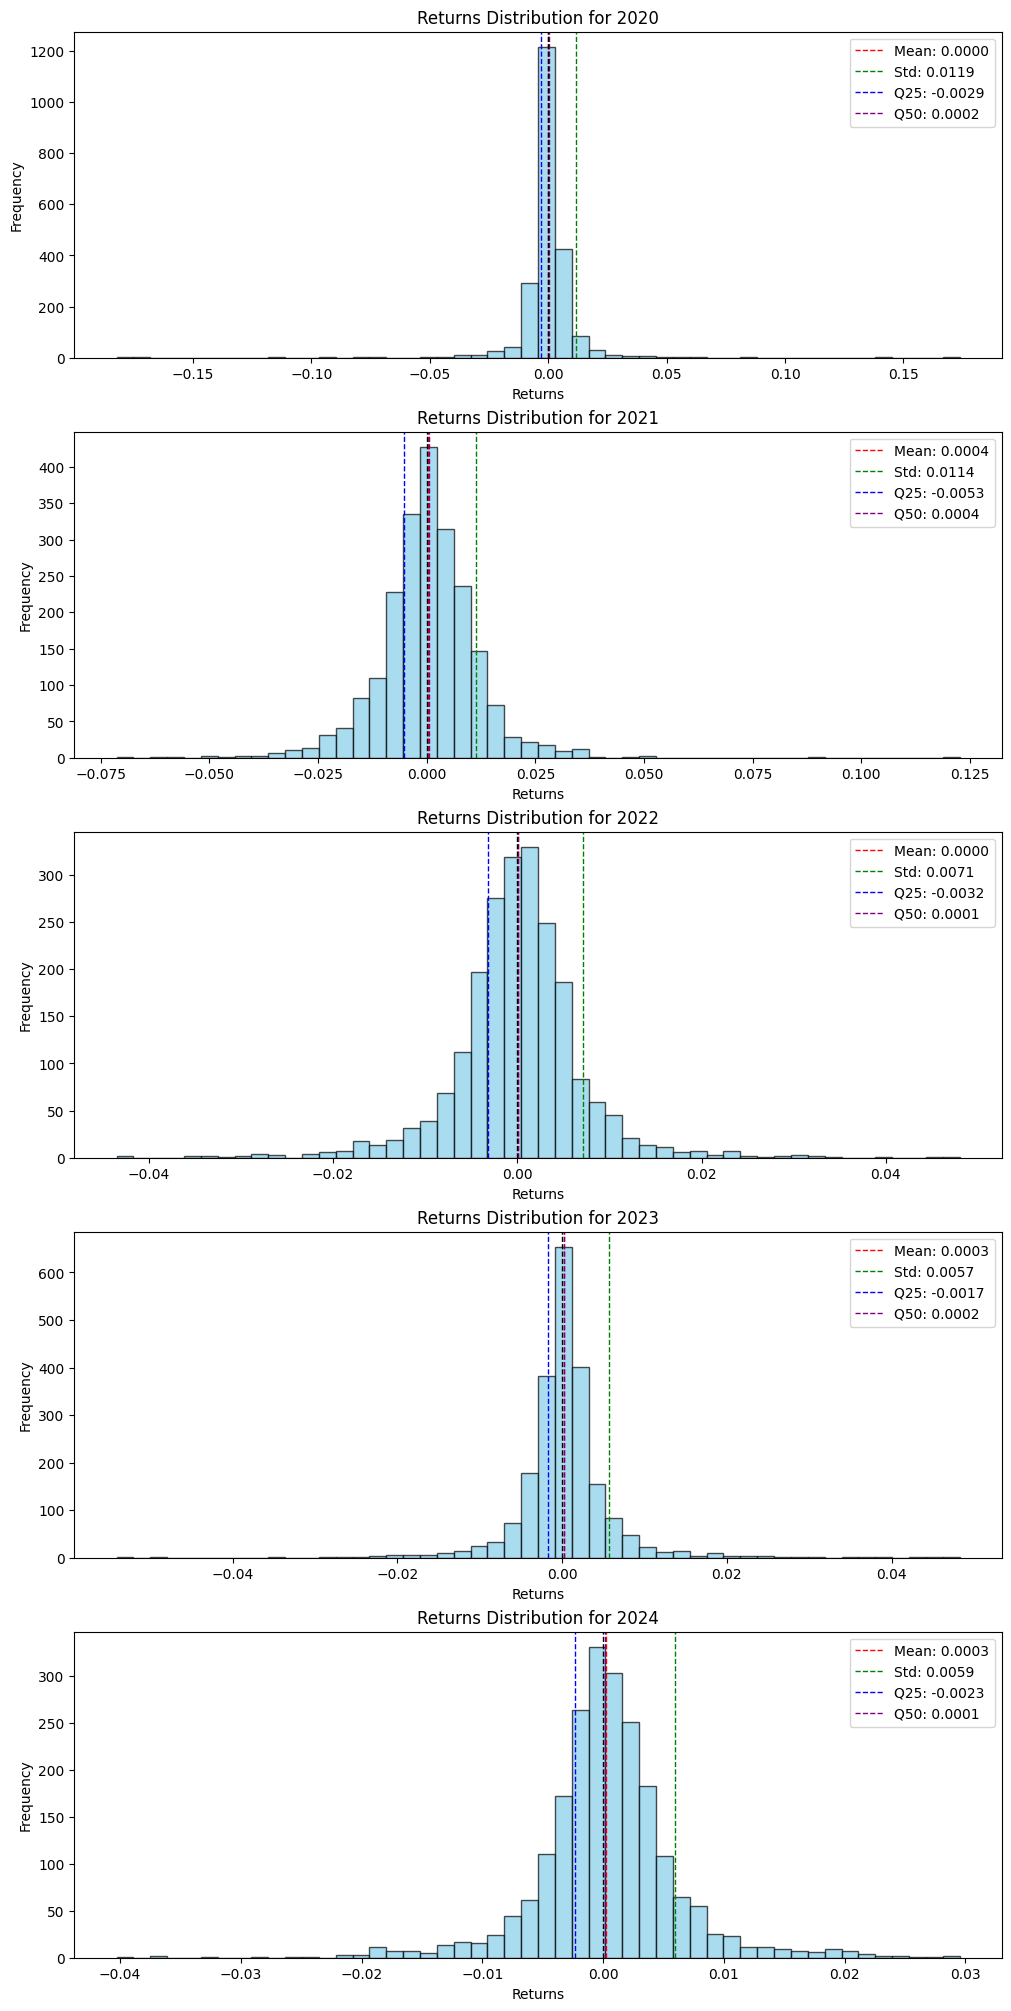

,year,mean,std,q25,q50
0,2020,0.000021,0.011916,-0.002851,0.000159
1,2021,0.000390,0.011427,-0.005318,0.000418
2,2022,0.000020,0.007140,-0.003162,0.000083
3,2023,0.000270,0.005702,-0.001687,0.000184
4,2024,0.000255,0.005945,-0.002339,0.000143


In [12]:
df_spot_btc_q1 = df_spot_btc[df_spot_btc['quarter'] == 1].copy()
plot_returns_distribution(df_spot_btc_q1)

- positive skewed returns in Q1
- more positive distribution in q1 compared to overall

In [13]:
def get_hyperliquid_funding(instrument, startTime, endTime = int(datetime.now(tz=pytz.UTC).timestamp() * 1000)):
    url = f"""https://api.hyperliquid.xyz/info"""
    headers = {
        "Content-Type" : "application/json",
    }
    all_data = []

    query_time = startTime
    print(f"""Hyperliquid : Querying funding data for {instrument} from {datetime.fromtimestamp(startTime/1000).strftime("%Y-%m-%d %H:%M:%S")} to {datetime.fromtimestamp(endTime/1000).strftime("%Y-%m-%d %H:%M:%S")}""")
    while query_time < endTime:
        payload = {
            "type": "fundingHistory",
            "coin": instrument,
            "startTime": query_time,
            "endTime": endTime
        }
        response = requests.post(url, headers=headers, json=payload)
        # return response.text
        if response.status_code != 200:
            raise Exception(f"Error {response.status_code} : {response.text}")
        data = response.json()
        if len(data) == 0:
            break
        all_data.extend(data)

        # update query_time
        query_time = data[-1]['time'] + 1

    return all_data

startTime = int(datetime(2023, 7, 1, 0, 0, 0, tzinfo=pytz.UTC).timestamp() * 1000)
endTime = int(datetime(2024, 12, 31, 23 , 59, tzinfo=pytz.UTC).timestamp() * 1000)
data = get_hyperliquid_funding(instrument='BTC', startTime=startTime, endTime=endTime)
hl_df = pd.DataFrame(data)
hl_df['premium'] = hl_df['premium'].astype(float)
hl_df['fundingRate'] = hl_df['fundingRate'].astype(float)
hl_df['datetime'] = pd.to_datetime(hl_df['time'], unit='ms')
hl_df

Hyperliquid : Querying funding data for BTC from 2023-07-01 08:00:00 to 2025-01-01 07:59:00


,coin,fundingRate,premium,time,datetime
0,BTC,0.000051,0.000407,1688169600189,2023-07-01 00:00:00.189
1,BTC,0.000058,0.000463,1688173200008,2023-07-01 01:00:00.008
2,BTC,0.000049,0.000390,1688176800067,2023-07-01 02:00:00.067
3,BTC,0.000045,0.000361,1688180400024,2023-07-01 03:00:00.024
4,BTC,0.000040,0.000319,1688184000166,2023-07-01 04:00:00.166
...,...,...,...,...,...
13192,BTC,0.000013,0.000588,1735671600057,2024-12-31 19:00:00.057
13193,BTC,0.000013,0.000607,1735675200076,2024-12-31 20:00:00.076
13194,BTC,0.000013,0.000603,1735678800120,2024-12-31 21:00:00.120
13195,BTC,0.000020,0.000660,1735682400002,2024-12-31 22:00:00.002


[3.86170731e-05 1.84851812e-05 1.55614670e-05 ... 1.86073443e-05
 5.43542603e-05 6.37925485e-05]
[-0.0041916   0.00142693  0.0022745  ...  0.0013917  -0.0083453
 -0.01074723]
[ 3.08709688e-05 -4.15779433e-06  5.06836494e-05 ...  2.98241007e-05
  5.45491694e-05  1.28614898e-05]
[-0.00207284  0.00822828 -0.00739364 ... -0.01139828 -0.0017825
 -0.00839555]
[ 3.28063187e-07  6.66389967e-05 -1.94321451e-05 ...  2.74218878e-05
  5.24897991e-05  4.46935796e-05]
[ 0.00683548 -0.01145936  0.01316083 ...  0.01650741 -0.00111253
 -0.00786317]
[ 2.35757913e-05  3.09643750e-05 -1.41795827e-05 ...  2.45570048e-05
  2.82346252e-05  5.10660874e-05]
[-2.88678553e-05 -2.09870358e-03  1.14298009e-02 ... -5.23809125e-03
 -3.06635411e-04 -1.33977996e-03]
[4.15196821e-05 6.36181984e-05 3.58546205e-05 ... 4.08750770e-05
 9.79615124e-05 8.85425542e-05]
[-0.0049725  -0.01070343 -0.00344189 ... -0.00195533  0.01209614
 -0.00479968]
[-2.44878361e-06  6.62669036e-05 -8.24353490e-06 ... -3.15567500e-05
  1.4595305

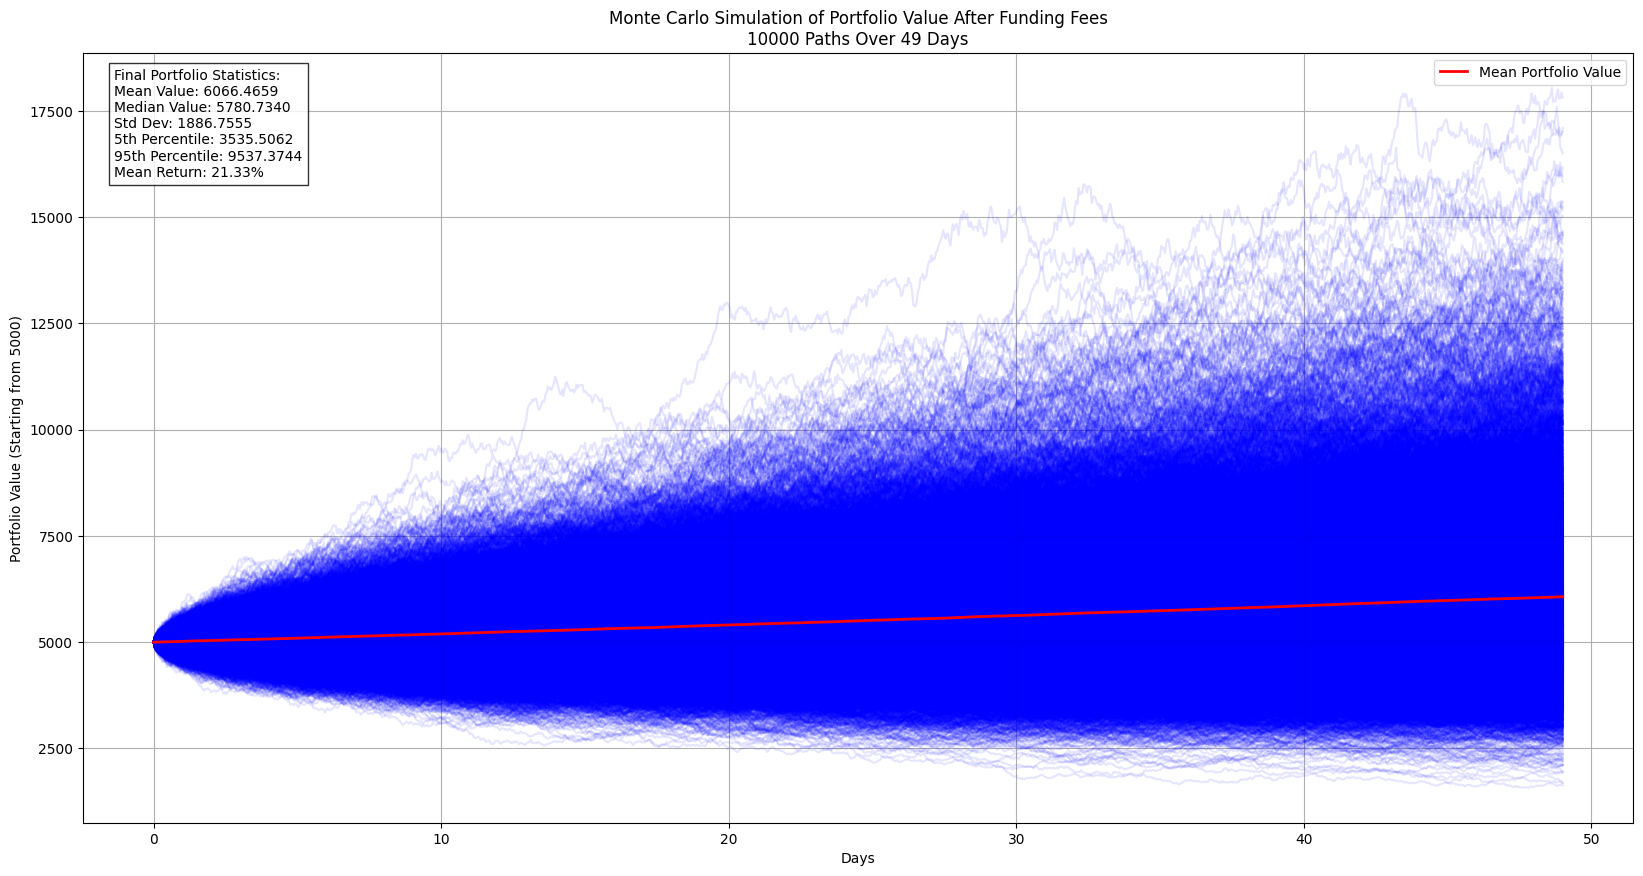

In [14]:
from scipy import stats

def generate_samples(data, n_steps, dist_type='kde', random_state=None):
    # Set random state for reproducibility
    if random_state is not None:
        np.random.seed(random_state)
    
    if dist_type == 'kde':
        # For KDE, we need to set the random state explicitly
        kde = stats.gaussian_kde(data)
        # Store the original random state
        original_state = np.random.get_state()
        # Set the random state for this specific sampling
        np.random.seed(random_state)
        samples = kde.resample(n_steps)[0]
        # Restore the original random state
        np.random.set_state(original_state)
        return samples
    
    # elif dist_type == 'gamma':
    #     # Fit gamma distribution parameters
    #     shape, loc, scale = stats.gamma.fit(data)
    #     # Generate samples with explicit random_state
    #     return stats.gamma.rvs(shape, loc=loc, scale=scale, 
    #                          size=n_steps, random_state=random_state)
    
    elif dist_type == 'pearson':
        # Fit Pearson Type III distribution parameters
        shape, loc, scale = stats.pearson3.fit(data)
        # Generate samples with explicit random_state
        return stats.pearson3.rvs(shape, loc=loc, scale=scale, 
                                size=n_steps, random_state=random_state)
    
    else:
        raise ValueError(f"Unsupported distribution type: {dist_type}")


def simulate_portfolio_fundingandreturns(funding_rates_df, hourly_funding_col, returns_df, returns_col, num_simulations, duration_hours, dist_type, initial_size, random_state = 42):
    rates = funding_rates_df[hourly_funding_col].values
    returns = returns_df[returns_col].values

    # Initialize arrays
    funding_rates = np.zeros((num_simulations, duration_hours))
    returns_data = np.zeros((num_simulations, duration_hours))
    total_fees = np.zeros(num_simulations)
    portfolio_values = np.zeros((num_simulations, duration_hours + 1))
    
    portfolio_values[:, 0] = initial_size

    for i in range(num_simulations):
        funding_rates[i] = generate_samples(data=rates, n_steps=duration_hours, dist_type=dist_type, random_state=random_state + i)
        returns_data[i] = generate_samples(data=returns, n_steps=duration_hours, dist_type=dist_type, random_state=random_state + i)
        print(funding_rates[i])
        print(returns_data[i])
        fees = 0

        for t in range(duration_hours):
            portfolio_values[i, t + 1] = portfolio_values[i, t] * (1 + returns_data[i, t])
            funding_payment = portfolio_values[i, t] * (funding_rates[i, t])
            portfolio_values[i, t + 1] -= funding_payment
            fees += funding_payment
            total_fees[i] = fees

    # Create visualization
    plt.figure(figsize=(20, 10))
    time_points = np.arange(duration_hours + 1)
    
    # Plot all individual paths with low opacity
    for path in portfolio_values:
        plt.plot(time_points / 24, path, color='blue', alpha=0.1)
    
    # Plot mean path with higher visibility
    mean_path = np.mean(portfolio_values, axis=0)
    plt.plot(time_points / 24, mean_path, color='red', linewidth=2, 
             label='Mean Portfolio Value')
    # Add summary statistics
    final_values = portfolio_values[:, -1]
    total_return = (final_values - initial_size) / initial_size * 100
    
    plt.text(0.02, 0.98, 
             f'Final Portfolio Statistics:\n' +
             f'Mean Value: {np.mean(final_values):.4f}\n' +
             f'Median Value: {np.median(final_values):.4f}\n' +
             f'Std Dev: {np.std(final_values):.4f}\n' +
             f'5th Percentile: {np.percentile(final_values, 5):.4f}\n' +
             f'95th Percentile: {np.percentile(final_values, 95):.4f}\n' +
             f'Mean Return: {np.mean(total_return):.2f}%',
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top')
    
    plt.xlabel('Days')
    plt.ylabel(f'Portfolio Value (Starting from {initial_size})')
    plt.title(f'Monte Carlo Simulation of Portfolio Value After Funding Fees\n'
              f'{num_simulations} Paths Over {duration_hours/24:.0f} Days')
    plt.legend()
    plt.grid(True)
    plt.show()
    return portfolio_values, funding_rates, returns_data, total_fees

portfolio_values_q1returns, funding_rates_q1returns, returns_q1returns, total_fees_q1returns = simulate_portfolio_fundingandreturns(
    funding_rates_df=hl_df,
    hourly_funding_col='fundingRate',
    returns_df=df_spot_btc_q1.dropna(),
    returns_col='returns',
    num_simulations=10000,
    duration_hours= 24 * 49,
    dist_type='pearson',
    initial_size=5000
)

In [22]:
pd.DataFrame(portfolio_values_q1returns).to_csv("portfolio_values_q1returns.csv", index=False)

In [23]:
pd.DataFrame(funding_rates_q1returns).to_csv("funding_rates_q1returns.csv", index=False)

In [24]:
pd.DataFrame(returns_q1returns).to_csv("returns_q1returns.csv", index=False)

In [25]:
pd.DataFrame(total_fees_q1returns).to_csv("total_fees_q1returns.csv", index=False)

# Reality vs Performance

## PnL

In [57]:
portfolio_values = pd.read_csv("portfolio_values_q1returns.csv")
final_pnl_values = portfolio_values.iloc[:, -1].values - 5000
final_pnl_values

array([-1242.7811613 , -1054.4524336 ,   839.49271516, ...,
        2364.02591686,   351.4103499 ,   140.83701935])

In [78]:
final_pnl_values.mean()

1066.4659136255104

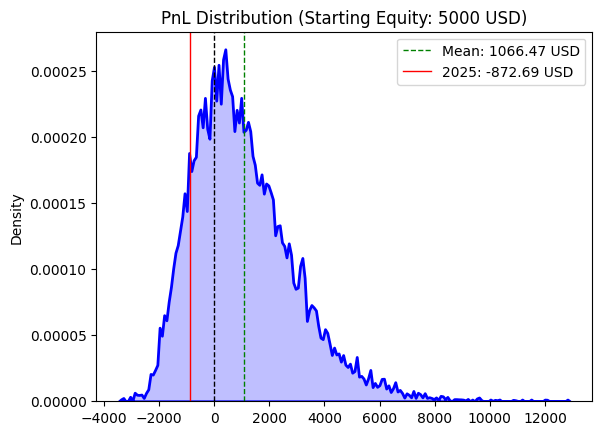

In [79]:
sns.kdeplot(
    final_pnl_values,
    bw_adjust=0.1,           # Lower = more detailed (narrower bandwidth)
    fill=True,               # Optional: fill under the curve
    linewidth=2,
    color='blue',
    # label='Portfolio Value Distribution'
)
plt.axvline(np.mean(final_pnl_values), color='green', linestyle='dashed', linewidth=1, label=f'Mean: {final_pnl_values.mean():.2f} USD')
plt.axvline(-872.69, color = 'red', linestyle='-', linewidth=1, label='2025: -872.69 USD')
plt.axvline(0, color='black', linestyle='dashed', linewidth=1)
plt.title("PnL Distribution (Starting Equity: 5000 USD)")
plt.legend()

# Final Portfolio Value: 1627.31
# Funding Fees: -44.43

In [80]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(final_pnl_values)
cdf_at_value = kde.integrate_box_1d(-np.inf, -872.69)
print(f"CDF at value {-872.69}: {cdf_at_value:.4f}")

CDF at value -872.69: 0.1367


## Funding

In [59]:
funding_values = pd.read_csv("total_fees_q1returns.csv")
funding_values

,0
0,133.682568
1,135.574230
2,147.974372
3,213.225764
4,167.363940
...,...
9995,158.111648
9996,134.764827
9997,167.265042
9998,144.653153


In [70]:
funding_values.mean()[0]

/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_9754/3396992685.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  funding_values.mean()[0]


158.352321884611

/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_9754/234440190.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.axvline(np.mean(funding_values), color='green', linestyle='dashed', linewidth=1, label=f'Mean: {funding_values.mean()[0]:.2f} USD')


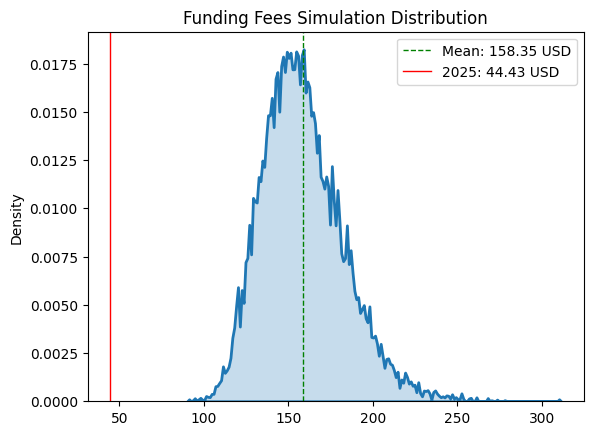

In [74]:
sns.kdeplot(
    funding_values,
    bw_adjust=0.1,           # Lower = more detailed (narrower bandwidth)
    fill=True,               # Optional: fill under the curve
    linewidth=2,
    color='green',
    # label='Portfolio Value Distribution'
)
# plt.axvline(np.mean(final_pnl_values), color='green', linestyle='dashed', linewidth=1, label='Mean')
# plt.axvline(-872.69, color = 'red', linestyle='-', linewidth=1, label='PnL 2025')
# plt.axvline(0, color='black', linestyle='dashed', linewidth=1, label='0')
# plt.title("PnL Distribution (Starting: 5000 USD)")
# plt.legend()
plt.axvline(np.mean(funding_values), color='green', linestyle='dashed', linewidth=1, label=f'Mean: {funding_values.mean()[0]:.2f} USD')
plt.axvline(44.43, color = 'red', linestyle='-', linewidth=1, label='2025: 44.43 USD')
plt.title("Funding Fees Simulation Distribution")
plt.legend()
